# Assignment 2: Python for Text Processing

**Submission deadline:** Friday, 31 Oct 2025, 11:55 PM  
**Assessment marks:** 35 marks (35% of the total unit assessment)

---

### Late Submission Penalty

Unless a Special Consideration request has been submitted and approved, a 5% penalty (of the total possible mark of the task) will be applied for each day a written report or presentation assessment is not submitted, up until the 7th day (including weekends). After the 7th day, a grade of ‘0’ will be awarded even if the assessment is submitted.

> **Example:** If the assignment is worth 8 marks (of the entire unit) and your submission is late by 19 hours (or 23 hours 59 minutes 59 seconds), 0.4 marks (5% of 8 marks) will be deducted. If your submission is late by 24 hours (or 47 hours 59 minutes 59 seconds), 0.8 marks (10% of 8 marks) will be deducted, and so on.

The submission time for all uploaded assessments is **11:55 PM**. A **1-hour grace period** is provided for technical concerns.  Apply for [Special Consideration](https://students.mq.edu.au/study/assessment-exams/special-consideration), if you think you should be granted an extended deadline or waive the late submission penalty. You should apply immediately when the situation occurs.

---

### Academic Integrity

All submitted work must be your own. For rules around AI tools, refer to **"Using Generative AI Tools" on iLearn**.

---

## Instructions

* Complete the five tasks below.

* Write your code and comments inside this notebook.

* Your notebook must include the running outputs of your final code.

* **Submit this `.ipynb` file, containing your code and outputs, to iLearn.**

---

### Assessment

-  Marks are based on the correctness of your code, outputs, and coding style.
-  A total of **2.5 marks** (0.5 per task) are awarded globally across the assignment for both of the below: (1) runnable codes; (2) good coding style: clean, modular code, meaningful variable names, and good comments.
-  If outputs are missing or incorrect, up to **25% of the marks for that task** can be deducted.
-  See each task below for the detailed mark breakdown.

---

### AI Tools Usage Policy


In this assignment, we view AI code generators such as copilot, CodeGPT, etc as tools that can help you write code quickly. You are allowed to use these tools, but with some conditions. To understand what you can and what you cannot do, please visit these information pages provided by Macquarie University.

- See: [Artificial Intelligence Tools and Academic Integrity in FSE](https://bit.ly/3uxgQP4)

If you choose to use these tools, make the following explicit in your submitted file as comments starting with "Use of AI generators in this assignment" :

- What part of your code is based on the output of such tools,
- What tools you used,
- What prompts you used to generate the code or text, and
- What modifications you made on the generated code or text?

This will help us assess your work fairly. 

**If we observe that you have used an AI generator and you do not give the above information, you may face disciplinary action.**





## Objectives of this assignment

In this assignment, you will work on the Quora Question Pairs (QQP) datset detailed below. The first two tasks will help you get familiar with the data, and the remaining requires you to implement deep neural networks.


**About the Quora Question Pairs (QQP) Dataset**

Description: A large dataset of 400k+ question pairs from Quora, labeled whether they are duplicates (semantically the same) or not. It features informal, noisy text with class imbalance, hard positives (low lexical overlap) and hard negatives (high overlap, different meaning). QQP is practically relevant for deduplicating FAQs, search, and support systems. Working on QQP builds transferable skills, such as text preprocessing, model comparison, threshold tuning, error analysis, and deployment-minded reasoning about real applications.

**Get familiar with the dataset**

In [187]:
!pip -q install datasets    # Install the datasets package to access the dataset
# add the packages you used, and specify the verion you installed

# All required import for the assignment.
from datasets import load_dataset
import numpy as np
import nltk

from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from collections import Counter

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [188]:
'''
Selecting the device to run the model on.
cuda - Nvidia GPU
mps - Apple M1 GPU
cpu - CPU of the device
'''
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")


print("The device is:", DEVICE)

The device is: mps


In [191]:
# Set random seeds for reproducibility
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [192]:
# 1) Load QQP
ds = load_dataset("glue", "qqp")

# Use validation set as our test; optionally create a smaller train subset for speed
train_ds = ds["train"]
eval_ds  = ds["validation"]

q1_tr = list(train_ds["question1"])
q2_tr = list(train_ds["question2"])
y_tr  = np.array(train_ds["label"])

q1_te = list(eval_ds["question1"])
q2_te = list(eval_ds["question2"])
y_te  = np.array(eval_ds["label"])

### Task 1. What is the top-5 common NOUN in the question1 and question2, respectively? (5 marks)

Write codes that returns the top-5 common NOUN in the questions. To find the part of speech, use NLTK's "Universal" tag set. You may need to use NLTK's `sent_tokenize` and `word_tokenize` to get words. The function returns a list that is descendingly sorted according to freqency, e.g. [(noun1, 22), (noun2, 10), ...].
<!-- To produce the correct results, the function must do this.  -->
Hint: The following steps will produce the correct results:

- Concatenate all questions together.
- Use the NLTK libraries to find the tokens and the stems.
- Use NLTK's sentence tokeniser before NLTK's word tokeniser.
- Use NLTK's part of speech tagger, using the "Universal" tagset.
- Use NLTK's `pos_tag_sents` instead of `pos_tag`.

Marking Criteria: 
- 2.5 marks for the correct codes and results of each column, namely question1 and question2 columns.




In [197]:
def get_word_tokens(data):
    '''
    Tokenizes the input data into word tokens.
    Args:
        data (list): A list of strings to be tokenized.
    Returns:
        list: A list of lists, where each sublist contains word tokens of a sentence.

    Joins the list of sentences into a single string, then splits it into sentences,
    and finally tokenizes each sentence into words.
    '''
    sep = ' '
    joined_data = sep.join(data)
    wt = [nltk.word_tokenize(s) for s in nltk.sent_tokenize(joined_data)]
    return wt

In [198]:
# Stemming
stemmer = nltk.PorterStemmer()

def get_stems(word_tokens):
    '''
    Stems the word tokens using Porter Stemmer.
    Args:
        word_tokens (list): A list of lists, where each sublist contains word tokens of a sentence.
    Returns:
        list: A list of lists, where each sublist contains stemmed word tokens of a sentence.
    '''
    return [[stemmer.stem(token.lower()) for token in sentence] for sentence in word_tokens]


In [ ]:
def get_tagged_words(word_token):
    '''
    Tags the word tokens with their respective parts of speech using "universal" tagset.
    Args:
        word_token (list): A list of lists, where each sublist contains word tokens of a sentence.
    Returns:
        list: A list of lists, where each sublist contains tuples of word tokens and their POS tags.
    '''
    tagged_words_list = nltk.pos_tag_sents(word_token, tagset='universal')
    return tagged_words_list

In [200]:
def get_most_common_nouns(tagged_words_list, n_top=5):
    '''
    Finds the most common nouns in the tagged words list.
    Args:
        tagged_words_list (list): A list of lists, where each sublist contains tuples of word tokens and their POS tags.
        n_top (int): The number of most common nouns to return.
    Returns:
        list: A list of tuples, where each tuple contains a noun and its frequency.
    '''
    tagged_nouns = [
        stemmer.stem(tagged_word[0].lower())
        for tagged_words in tagged_words_list
        for tagged_word in tagged_words
        if tagged_word[1] == 'NOUN'
    ]
    noun_counter = Counter(tagged_nouns)
    return noun_counter.most_common(n_top)


In [201]:
q1_tr_word_token = get_word_tokens(q1_tr)
q2_tr_word_token = get_word_tokens(q2_tr)

q1_tr_stem_token = get_stems(q1_tr_word_token)
q2_tr_stem_token = get_stems(q2_tr_word_token)

In [202]:
q1_tr_tagged_words = get_tagged_words(q1_tr_word_token)
q2_tr_tagged_words = get_tagged_words(q2_tr_word_token)

In [203]:
most_common_nouns_in_q1 = get_most_common_nouns(q1_tr_tagged_words)
most_common_nouns_in_q2 = get_most_common_nouns(q2_tr_tagged_words)

print('Top 5 most common nouns in question1:', most_common_nouns_in_q1)
print('Top 5 most common nouns in question2:', most_common_nouns_in_q2)


Top 5 most common nouns in question1: [('india', 12708), ('peopl', 11507), ('way', 10598), ('differ', 8623), ('quora', 7678)]
Top 5 most common nouns in question2: [('india', 13491), ('peopl', 12281), ('way', 11900), ('quora', 7967), ('time', 7579)]


### Task 2. What are the top-5 common stem 2-grams and non-stem 2-grams for question1 and question2, respectively? (5 marks)

Write codes that returns the top-5 most frequent 2-grams (bigrams) of stemmed and non-stemmed tokens along with their normalized frequency from the question1 and question2 columns of the QQP dataset. The output should be in descending order of frequency, **with frequencies normalized by the total number of bigrams (rounded to 4 decimal places)**, e.g., `[(('what', 'is'), 0.0105), (('what', 'are'), 0.0053), ...]`.

<!-- To produce the correct results, the function must do this: -->

Hint: The following steps will produce the correct results:

- Concatenate all questions together.
- Use NLTK's sentence tokeniser before NLTK's word tokeniser.
- Use the NLTK libraries to find the tokens and the stems.
- Use NLTK's Porter stemmer to get the root words.
- Round normalized frequency to 4 precision after the decimal point.
- When computing bigrams, do not consider words that are in different sentences. For example, if we have this text: `Sentence 1. And sentence 2.` the bigrams are: `('Sentence','1'), ('1','.'), ('.','And'), ('And','sentence')`, etc. Note that the following would not be a valid bigram, since the punctuation mark and the word "And" are in different sentences: `('.','And')`.

Marking Criteria: 
- 2.5 marks for the correct codes and restuls of each column, namely question1 and question2 columns.

In [ ]:
def get_top_bigrams(token_sequences, top_n=5):
    '''
    Computes the top N most common bigrams from the token sequences using "nltk.bigrams()".
    Args:
        token_sequences (list): A list of lists, where each sublist contains word tokens of a sentence.
        top_n (int): The number of most common bigrams to return.
    Returns:
        list: A list of tuples, where each tuple contains a bigram (as a tuple of two words) and its relative frequency.
    '''

    bigram_counts = Counter()
    total_bigrams = 0
    for sentence in token_sequences:
        normalized_tokens = [token.lower() for token in sentence]
        sentence_bigrams = list(nltk.bigrams(normalized_tokens))
        bigram_counts.update(sentence_bigrams)
        total_bigrams += len(sentence_bigrams)

    return [(bigram, round(count / total_bigrams, 4))for bigram, count in bigram_counts.most_common(top_n)]


In [205]:
q1_top_bigrams = get_top_bigrams(q1_tr_word_token)
q1_top_stem_bigrams = get_top_bigrams(q1_tr_stem_token)
q2_top_bigrams = get_top_bigrams(q2_tr_word_token)
q2_top_stem_bigrams = get_top_bigrams(q2_tr_stem_token)

print('Question1 top-5 non-stem bigrams:', q1_top_bigrams)
print('Question1 top-5 stem bigrams:', q1_top_stem_bigrams)

print('Question2 top-5 non-stem bigrams:', q2_top_bigrams)
print('Question2 top-5 stem bigrams:', q2_top_stem_bigrams)


Question1 top-5 non-stem bigrams: [(('what', 'is'), 0.0128), (('is', 'the'), 0.0112), (('what', 'are'), 0.0102), (('how', 'do'), 0.0084), (('can', 'i'), 0.0067)]
Question1 top-5 stem bigrams: [(('what', 'is'), 0.0128), (('is', 'the'), 0.0112), (('what', 'are'), 0.0102), (('how', 'do'), 0.0084), (('can', 'i'), 0.0067)]
Question2 top-5 non-stem bigrams: [(('what', 'is'), 0.0123), (('is', 'the'), 0.0108), (('what', 'are'), 0.0098), (('how', 'do'), 0.0085), (('can', 'i'), 0.0068)]
Question2 top-5 stem bigrams: [(('what', 'is'), 0.0123), (('is', 'the'), 0.0108), (('what', 'are'), 0.0098), (('how', 'do'), 0.0085), (('can', 'i'), 0.0068)]


### Task 3. Naïve Bayes Classifier (5.5 marks)

The QQR dataset contains pairs of questions with labels indicating whether the two questions are semantically duplicate (1) or not (0).

1. Using a Bag-of-Words representation, train a Naïve Bayes classifier to predict duplicates. (2 marks)

1. Report accuracy, precision, and recall on the test set. (1.5 marks)

1. Inspect your confusion matrix. Identify one type of error (false positive or false negative) that dominates. Suggest a possible reason for this pattern based on the dataset. (2 mark)

**1. Using a Bag-of-Words representation, train a Naïve Bayes classifier to predict duplicates.**

In [206]:
# From now on, you are allowed to use a subset of the dataset which requires less computing resources.
# Note that you have to use the same subset for the following coding tasks, which ensure fairness when comparing performance across different models.

Ntrain = 1000
Ntest = 100
ds = load_dataset("glue", "qqp")

# Use validation set as our test; optionally create a smaller train subset for speed
train_ds = ds["train"].select(range(Ntrain))
eval_ds  = ds["validation"].select(range(Ntest))

In [ ]:
# Using the entire training set for fitting
q1_train = list(train_ds['question1'])
q2_train = list(train_ds['question2'])
y_train = np.array(train_ds['label'])

# Test set
q1_test = list(eval_ds['question1'])
q2_test = list(eval_ds['question2'])
y_test = np.array(eval_ds['label'])


In [ ]:
'''
Using CountVectorizer from sklearn to create a bag-of-words representation for both questions.
Taking 1500 most frequent unigrams and bigrams from the training set of question1 and question2.
'''
vectorizer = CountVectorizer(max_features=1500, ngram_range=(1, 2))
vectorizer.fit(q1_train + q2_train)

'''
vectorizer.transform() -  creates a sparse matrix representation of the questions using the vocabulary of 5000.
hstack() -  horizontally stacks the sparse matrices horizontally to create one matrix.
This helps Naive Bayes Classifer to access both pair of questions at once to learn the relationship between them and identify if they are duplicates.
'''
X_train = hstack([
    vectorizer.transform(q1_train),
    vectorizer.transform(q2_train),
])

X_test = hstack([
    vectorizer.transform(q1_test),
    vectorizer.transform(q2_test),
])

In [ ]:
# Using sklearn's MultinomialNB to fit a Naive Bayes classifier on the bag-of-words representation.
clf = MultinomialNB()

# Training model
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
nb_train_accuracy = accuracy_score(y_train, train_predictions)
test_predictions = clf.predict(X_test)

print(f"Training accuracy: {nb_train_accuracy:.4f}")


Training accuracy: 0.9050


In [ ]:
# Testing model

nb_confusion = confusion_matrix(y_test, test_predictions)
nb_accuracy = accuracy_score(y_test, test_predictions)
nb_precision = precision_score(y_test, test_predictions, zero_division=0)
nb_recall = recall_score(y_test, test_predictions, zero_division=0)


**2. Report accuracy, precision, and recall on the test set.**

In [ ]:
# Accuracy, Precision, Recall for Test set
print(f"Test accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"Confusion Matrix:\n{nb_confusion}")


Test accuracy: 0.7200
Precision: 0.5417
Recall: 0.4333
Confusion Matrix:
[[59 11]
 [17 13]]


**Analysis of Accuracy, Precision and Recall:**
> The Naive Bayes classifier achieved a test accuracy of 72%, indicating that it correctly predicted the duplicate or non-duplicate label for most question pairs. However, the precision score of 0.54 and recall score of 0.43 reveal certain limitations in its performance. 
A precision of 0.54 suggests that only about half of the pairs predicted as duplicates were actually true duplicates, reflecting a moderate rate of false positives. The recall of 0.43 indicates that the model correctly identified less than half of the actual duplicate pairs, meaning it frequently missed true duplicates. To conclude, while the classifier performs reasonably well in distinguishing non-duplicate pairs, it struggles to capture deeper semantic similarities between questions. This is a typical issue Bag-of-Words-based models, which rely on surface-level word overlap and fail to account for contextual or paraphrased expressions.

**3. Inspect your confusion matrix. Identify one type of error (false positive or false negative) that dominates. Suggest a possible reason for this pattern based on the dataset.**

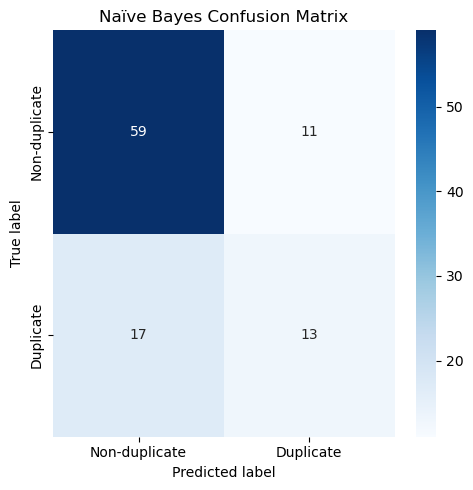

In [ ]:
'''
Visualising the confusion matrix helps explain whether false positives or false negatives dominate, 
addressing the error-analysis requirement for Task 3.
'''

# Task 3: Visualise Naive Bayes confusion matrix
plt.figure(figsize=(5, 5))
class_labels = ['Non-duplicate', 'Duplicate']
sns.heatmap(
    nb_confusion, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_labels, yticklabels=class_labels
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Naive Bayes Confusion Matrix')
plt.tight_layout()
plt.show()



**Analysis of Confusion Matrix:**
> The confusion matrix shows that false negatives (17) outnumber false positives (11), indicating that the model more frequently fails to recognize actual duplicate question pairs. This suggests that the classifier is conservative in predicting duplicates, often labeling semantically similar questions as non-duplicates. Similar to analysis of accuracy, precision and recall, having only surface-level data and ignoring contextual or paraphrased meaning causes model to perform bad.

### Task 4. Siamese Neural Network (7 marks)

You now want to learn semantic similarity directly from the question pairs.

1. Design a Siamese Neural Network with two identical LSTM encoders that embed each question. (3 marks)

1. Use cosine similarity to classify duplicates, and report accuracy and F1-score. (2 marks)

1. Compare your Siamese model to your Naïve Bayes model. Which one handles imbalanced errors (precision vs. recall) better in your results, and why do you think that is? (2 marks)

**1. Design a Siamese Neural Network with two identical LSTM encoders that embed each question.**

In [ ]:
from transformers import BertTokenizer

# Tokenizer
'''
Using pretrained BERT tokenizer as it already has a huge vocabulary learned from large corpus.
'''
TOKENIZER_NAME = "bert-base-uncased"
TOKENIZER = BertTokenizer.from_pretrained(TOKENIZER_NAME)
VOCAB_SIZE = TOKENIZER.vocab_size
PAD_TOKEN_ID = TOKENIZER.pad_token_id

# Hyper parameters
MAX_LEN = 80
EMBED_SIZE = 256
LSTM_UNITS = 256
BATCH_SIZE = 25
N_EPOCHS = 5
LEARNING_RATE = 1e-3
MARGIN = 1.0
DROPOUT = 0.1

In [268]:
class SiameseDataset(Dataset):
    '''
    Preping data for Siamese Network.
    Converts the sentences in to tensors for the model with data such as padding, tokenid, attention mask etc using tokenizer.encode_plus().
    '''

    def __init__(self, sents1, sents2, labels, tokenizer, max_len):
        self.sents1 = sents1
        self.sents2 = sents2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        '''
        Retrieves the tokenized input IDs and attention masks for both questions in the pair, along with the label.
        Args:
            idx (int): Index of the data point to retrieve.
        Returns:
            dict: A dictionary containing:
                'ids1': Tensor of input IDs for question 1.
                'ids2': Tensor of input IDs for question 2.
                'labels': Tensor of the label (0 or 1). 
        '''
        q1_text = str(self.sents1[idx])
        q2_text = str(self.sents2[idx])
        label = self.labels[idx]

        encoded1 = self.tokenizer.encode_plus(
            q1_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        encoded2 = self.tokenizer.encode_plus(
            q2_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'ids1': encoded1['input_ids'].flatten(),
            'ids2': encoded2['input_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float),
        }

In [289]:
class SiameseNetwork(nn.Module):
    '''
    Creating Siamese Network with shared LSTM encoders.
    nn.Embedding(): Converts input in to vectors with randomly initialized weights.
    nn.LSTM(): A Long Short-Term Memory (LSTM) layer for sequence modeling. Since the the entire question is already available at each time step, bidirectionality is not necessary here.
    nn.Dropout(): Using for regularization. randomly dropping a fraction of least important features.

    classifier: A feedforward neural network that takes the cosine similarity as input and outputs a logit score. 
                As we are using nn.BCEWithLogitsLoss(), we do not need to apply sigmoid activation here.
    '''

    def __init__(self, vocab_size=VOCAB_SIZE, pad_idx=PAD_TOKEN_ID, embed_dim=EMBED_SIZE, hidden_size=LSTM_UNITS, dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward_once(self, tokens):
        embedded = self.embedding(tokens)
        _, (hidden, _) = self.lstm(embedded)
        # Since LSTM is not bidirectional, hidden has shape (1, batch_size, hidden_size)
        return self.dropout(hidden[0])
        

    def forward(self, q1, q2):
        h1 = self.forward_once(q1)
        h2 = self.forward_once(q2)

        '''
        Using cosine similarity to classify duplicates.
        '''
        cosine = F.cosine_similarity(h1, h2, dim=1).unsqueeze(-1)
        logits = self.classifier(cosine).squeeze(-1)
        return logits

In [ ]:
# Training the model
def train_epoch(model, loader, optimiser, criterion, device):
    '''
    Args:
        model (nn.Module): The Siamese network model to be trained.
        loader (DataLoader): DataLoader for the training data.
        optimiser (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function to compute the loss.
        device (torch.device): Device to run the model on (CPU or GPU).
    Returns:
        float: Average loss over the epoch.
    '''

    # Model in training mode as we need to update the weights using backpropagation
    model.train()

    total_loss = 0.0
    
    for batch in loader:
        ids1 = batch['ids1'].to(device)
        ids2 = batch['ids2'].to(device)
        labels = batch['labels'].float().to(device)

        optimiser.zero_grad()
        logits = model(ids1, ids2)
        loss = criterion(logits, labels)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [271]:
def evaluate(model, loader, criterion, device):
    '''
    Args:
        model (nn.Module): The Siamese network model to be evaluated.
        loader (DataLoader): DataLoader for the evaluation data.
        criterion (nn.Module): Loss function to compute the loss.
        device (torch.device): Device to run the model on (CPU or GPU).
    Returns:
        tuple: A tuple containing average loss, accuracy, precision, recall, and F1-score.
    '''

    # Model in evaluation mode as we are evaluating and do not need to update weights
    model.eval()

    total_loss = 0.0
    all_probs, all_labels = [], []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for batch in loader:
            ids1 = batch['ids1'].to(device)
            ids2 = batch['ids2'].to(device)
            labels = batch['labels'].float().to(device)

            logits = model(ids1, ids2)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Converting logits to probabilities to compute threshold based metrics
    preds = (np.array(all_probs) >= 0.5).astype(float)
    labels_np = np.array(all_labels)

    accuracy = accuracy_score(labels_np, preds)
    precision = precision_score(labels_np, preds, zero_division=0)
    recall = recall_score(labels_np, preds, zero_division=0)
    f1 = f1_score(labels_np, preds, zero_division=0)

    return total_loss / len(loader), accuracy, precision, recall, f1

In [272]:
# Creating datasets and dataloaders for train and test sets
train_dataset = SiameseDataset(train_ds['question1'], train_ds['question2'], train_ds['label'], TOKENIZER, MAX_LEN)
test_dataset = SiameseDataset(eval_ds['question1'], eval_ds['question2'], eval_ds['label'], TOKENIZER, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [279]:
# Creating the Siamese model.
model = SiameseNetwork().to(DEVICE)

'''
Usiing Adam optimiser becasue it provides adaptive learning rate and momentum based updates wich is suited for architechture like LSTM.
It converges faster and more reliably than other optimisers like SGD.
'''
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

'''
Using BCEWithLogitsLoss because the Siamese network outputs logits that represent the similarity between two questions.
BCEWithLogitsLoss combines a sigmoid activation and binary cross-entropy in a single, numerically stable operation, converting logits into probabilities internally. 
'''
criterion = nn.BCEWithLogitsLoss()

'''
Traning the Siamese model and reporting loss per epoch.
Aftre multiple iteration, 5 epochs seemed to be most optimal for this dataset. After 5 epochs, the train loss hovers between 0.64 - 0.65 range.
'''
for epoch in range(1, N_EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimiser, criterion, DEVICE)
    print(f'Epoch {epoch}: train loss={train_loss:.4f}')
    

Epoch 1: train loss=0.7053
Epoch 2: train loss=0.6708
Epoch 3: train loss=0.6553
Epoch 4: train loss=0.6509
Epoch 5: train loss=0.6496


**2. Use cosine similarity to classify duplicates, and report accuracy and F1-score.**

In [280]:
'''
After training we compute accuracy, precision, recall, and F1.
'''

test_loss, siamese_accuracy, siamese_precision, siamese_recall, siamese_f1 = evaluate(model, test_loader, criterion, DEVICE)

print(f'Accuracy: {siamese_accuracy:.4f}')
print(f'Precision: {siamese_precision:.4f}')
print(f'Recall: {siamese_recall:.4f}')
print(f'F1 score: {siamese_f1:.4f}')

Accuracy: 0.7000
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


**Analysis:**
> The Siamese LSTM network achieved a test accuracy of 70%. The precision, recall, and F1-score are all 0.0, this indicats that the model consistently predicted all pairs as non-duplicates. This suggests that the network failed to distinguish between duplicate and non-duplicate questions. This is because the predictions are below the used 0.5 threshold. The network predicts between 0.3 adnd 0.4.

> Even after adjusting the hyperparamers such as initial weight of the loss function, epoch, learning rate, and cosine similarity from [-1.1] to [0,1]. the network prediction is not chagned.

**3. Compare your Siamese model to your Naïve Bayes model. Which one handles imbalanced errors (precision vs. recall) better in your results, and why do you think that is?**

In [ ]:
print(f"Naive Bayes: Accuracy: {nb_accuracy:.4f} | Precision: {nb_precision:.4f} | Recall: {nb_recall:.4f}")
print(f"Siamese Network: Accuracy: {siamese_accuracy:.4f} | Precision: {siamese_precision:.4f} | Recall: {siamese_recall:.4f}")


Naive Bayes: Accuracy: 0.7200 | Precision: 0.5417 | Recall: 0.4333
Siamese Network: Accuracy: 0.7000 | Precision: 0.0000 | Recall: 0.0000


**Analysis:**
> When comparing both the models, the Naive Bayes classifier handled imbalanced errors more effectively than the Siamese LSTM network. The Naive Bayes model achieved a test accuracy of 72%, with a precision of 0.54 and recall of 0.43, indicating that it was able to identify duplicate and non-duplicate questions with a reasonable trade off between false positives and false negatives. In contrast, the Siamese LSTM network obtained a similar accuracy of 70% but a precision and recall of 0.0, meaning it predicted all pairs as non-duplicates. This occurred because the model produced low similarity probabilities around 0.3 – 0.4 that never crossed the 0.5 classification threshold, leading to no positive (duplicate) predictions.

### Task 5. Transformer-Based Classifier (10 marks)

Instead of handcrafted features or LSTMs, you now fine-tune a pre-trained Transformer (e.g., BERT or RoBERTa, etc) for QQP.

1. Fine-tune the model for 3 epochs with learning rate 2e-5. (3 marks)

1. Report the accuracy, precision, recall, and F1-score. (2 marks)

1. Compare your Transformer results with your Siamese model. Did the Transformer improve both precision and recall, or mainly one? What does this suggest about how it captures question meaning? (2 marks)

1. Look at one example your Transformer misclassified. Write a short explanation of why the model might have made this mistake. (3 marks)

Task 5 switches to a Transformer encoder. We load the pretrained BERT tokenizer and record the fine-tuning hyperparameters specified in the brief.


In [291]:
'''
Selecting pretrained transformer model.
'''
TRANSFORMER_MODEL_NAME = 'bert-base-uncased'

'''
Setting hyperparameters for transformer model as specified in the task
'''
TRANSFORMER_EPOCHS = 3
TRANSFORMER_LR = 2e-5
TRANSFORMER_BATCH_SIZE = 16
TRANSFORMER_MAX_LEN = 128

transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

In [293]:
def tokenize_transformer(batch):
    '''
    Tokenizes the question pairs using the pretrained BERT tokenizer into numerical inputs for the model to train on.

    Args:
        batch (dict): A batch of data containing 'question1' and 'question2'.
    Returns:
        dict: A dictionary containing tokenized inputs for both questions.
    '''
    return transformer_tokenizer(
        batch['question1'],
        batch['question2'],
        padding='max_length',
        truncation=True,
        max_length=TRANSFORMER_MAX_LEN,
    )

In [ ]:

val_text_pairs = list(zip(eval_ds['question1'], eval_ds['question2']))

# Applies tokenize_transformer to the entire train and test datasets.
tokenized_train = train_ds.map(
    tokenize_transformer,
    batched=True,
    remove_columns=['question1', 'question2', 'idx'],
)

tokenized_test = eval_ds.map(
    tokenize_transformer,
    batched=True,
    remove_columns=['question1', 'question2', 'idx'],
)

# Huggingface transformers expect the label column to be named 'labels'
tokenized_train = tokenized_train.rename_column('label', 'labels')
tokenized_test = tokenized_test.rename_column('label', 'labels')

'''
It ensures that "token_type_ids" which is segment embeddings are correctly passed to the model, allowing the transformer model to understand which question is question1 and which is question2.
Since some models like BERT use segment embeddings to differentiate the two input questions.
'''
model_input_cols = ['input_ids', 'attention_mask', 'labels']
if 'token_type_ids' in tokenized_train.features:
    model_input_cols.insert(2, 'token_type_ids')

'''
 The set_format() method ensures that each model input field is represented as a PyTorch tensor.
'''
tokenized_train.set_format(type='torch', columns=model_input_cols)
tokenized_test.set_format(type='torch', columns=model_input_cols)

Map: 100%|██████████| 100/100 [00:00<00:00, 9433.25 examples/s]


In [ ]:
'''
We wrap the tokenised datasets in DataLoaders and instantiate the classification head from the pretrained BERT checkpoint, 
wiring up the AdamW optimiser and linear schedule required for stable fine-tuning.
'''

# Loading the data using DataLoader
train_loader = DataLoader(tokenized_train, batch_size=TRANSFORMER_BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(tokenized_test, batch_size=TRANSFORMER_BATCH_SIZE)

'''
AutoModelForSequenceClassification.from_pretrained(): Selects "bert-base-uncased" model and initializes it with pretrained weights.
num_labels=2: Modifies the final classification layer so that it outputs two logits.
'''
transformer_model = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_MODEL_NAME,
    num_labels=2,
).to(DEVICE)

optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=TRANSFORMER_LR)

total_training_steps = len(train_loader) * TRANSFORMER_EPOCHS

# fine tuning the model
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=max(1, int(0.1 * total_training_steps)),
    num_training_steps=total_training_steps,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**1. Fine-tune the model for 3 epochs with learning rate 2e-5.**

In [ ]:
# training the model
for epoch in range(1, TRANSFORMER_EPOCHS + 1):
    transformer_model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        outputs = transformer_model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch}/{TRANSFORMER_EPOCHS} - loss: {avg_epoch_loss:.4f}')



Epoch 1/3 - loss: 0.6370
Epoch 2/3 - loss: 0.4634
Epoch 3/3 - loss: 0.3241


**2. Report the accuracy, precision, recall, and F1-score.**

In [ ]:
# Evaluating the model
transformer_model.eval()
all_preds, all_labels = [], []
misclassified_idx = None
misclassified_pred = None
misclassified_true = None
example_idx = 0

default_eval_loss = 0.0
with torch.no_grad():
    for batch in eval_loader:
        labels = batch['labels']
        batch_on_device = {key: value.to(DEVICE) for key, value in batch.items()}
        outputs = transformer_model(**batch_on_device)
        default_eval_loss += outputs.loss.item()
        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels_np = labels.numpy()
        all_preds.extend(batch_preds.tolist())
        all_labels.extend(labels_np.tolist())
        for pred, true in zip(batch_preds, labels_np):
            if misclassified_idx is None and pred != true:
                misclassified_idx = example_idx
                misclassified_pred = int(pred)
                misclassified_true = int(true)
            example_idx += 1

transformer_accuracy = accuracy_score(all_labels, all_preds)
transformer_precision = precision_score(all_labels, all_preds, zero_division=0)
transformer_recall = recall_score(all_labels, all_preds, zero_division=0)
transformer_f1 = f1_score(all_labels, all_preds, zero_division=0)

print(f'Transformer accuracy: {transformer_accuracy:.4f}')
print(f'Transformer precision: {transformer_precision:.4f}')
print(f'Transformer recall: {transformer_recall:.4f}')
print(f'Transformer F1 score: {transformer_f1:.4f}')


Transformer accuracy: 0.7700
Transformer precision: 0.6207
Transformer recall: 0.6000
Transformer F1 score: 0.6102


**Analysis:**
> The fine tuned Transformer model achieved an accuracy of 77%, with a precision of 0.62, recall of 0.60, and an F1-score of 0.61. These results indicate that the model correctly classified most question pairs and maintained a balanced trade off between false positives and false negatives. Compared to earlier models, the Transformer demonstrated a stronger ability to capture contextual and semantic relationships between questions, leading to more consistent duplicate detection performance across both classes.

**3. Compare your Transformer results with your Siamese model. Did the Transformer improve both precision and recall, or mainly one? What does this suggest about how it captures question meaning?**

In [297]:
# We contrast both models to explain precision/recall trade offs, per assignment prompt
print(f"Fine tuned transformer model: Accuracy: {transformer_accuracy:.4f} | Precision: {transformer_precision:.4f} | Recall: {transformer_recall:.4f}")
print(f"Siamese Network: Accuracy: {siamese_accuracy:.4f} | Precision: {siamese_precision:.4f} | Recall: {siamese_recall:.4f}")


Fine tuned transformer model: Accuracy: 0.7700 | Precision: 0.6207 | Recall: 0.6000
Siamese Network: Accuracy: 0.7000 | Precision: 0.0000 | Recall: 0.0000


**Analysis:**
> The fine tuned Transformer model outperformed the Siamese LSTM network in every evaluation metric, showing significant improvements in both precision and recall. While the Siamese network achieved an accuracy of 70% with precision and recall values of 0.0 which indicates that it failed to identify any duplicate pairs. The Transformer model reached an accuracy of 77%, precision of 0.62, and recall of 0.60. This improvement across both metrics suggests that the Transformer not only reduced false positives but also became much better at detecting true duplicates. The results highlight that the Transformer effectively captures semantic meaning and contextual relationships between questions. The self attention mechanism and pretrained language understanding, which allow it to recognize paraphrases and related expressions beyond simple word overlap.

**4. Look at one example your Transformer misclassified. Write a short explanation of why the model might have made this mistake.**

In [298]:
if misclassified_idx is not None:
    mis_q1, mis_q2 = val_text_pairs[misclassified_idx]
    print('Misclassified example:')
    print('Question 1:', mis_q1)
    print('Question 2:', mis_q2)
    print(f'True label: {misclassified_true} - Predicted: {misclassified_pred}')
    print('Possible reason: The questions share almost all tokens, so the model fixates on lexical overlap and misses that the second query broadens to names starting with D or H, turning the pair into a near-duplicate despite different intent.')
else:
    print('Transformer classified all evaluation examples correctly on this subset.')



Misclassified example:
Question 1: What are some good baby girl names starting with D?
Question 2: What are some good baby girl names starting with D or H?
True label: 0 - Predicted: 1
Possible reason: The questions share almost all tokens, so the model fixates on lexical overlap and misses that the second query broadens to names starting with D or H, turning the pair into a near-duplicate despite different intent.


**Analysis:**
> In this example, the Transformer model likely focused on the strong lexical and structural overlap between the two questions and treated them as semantically the same. However, the second question subtly broadens the intent by adding “or H,” which makes it a different in meaning. Because most of the tokens, order, and topic match, the model inferred high similarity and predicted “duplicate”. This suggests the model is slightly over reliant on shared wording and less sensitive to small scope changes expressed through short modifiers like “or H.”